In [112]:
import pandas as pd
import geopandas as gpd
import requests
import os
import numpy as np
import math

from shapely.geometry import mapping, Polygon
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import xarray as xr
import rioxarray
import rasterio
import zipfile

from odc.stac import configure_rio, load

# For all the provinces in Argentina, which one has the highest correlation between a decrease in rainfall and an increase in violence?

### Get Argentinian Provinces

In [2]:
provinces = gpd.read_file("./data/states_provinces/ne_10m_admin_1_states_provinces.shp")

In [3]:
argentina = provinces.loc[(provinces['admin'] == 'Argentina')]
argentina.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 states provinces,3,ARG-1309,1309,AR-E,NaN,AR,1,Entre Ríos,Entre-Rios,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4..."
11,Admin-1 states provinces,3,ARG-1303,1303,AR-A,NaN,AR,1,Salta,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-67.28473 -23.83414, -67.25133 -23.7..."
12,Admin-1 states provinces,3,ARG-1301,1301,AR-Y,NaN,AR,1,Jujuy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-67.25133 -23.73309, -67.24791 -23.7..."
740,Admin-1 states provinces,3,ARG-1307,1307,AR-P,NaN,AR,1,Formosa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-62.34136 -22.47226, -62.30573 -22.4..."
745,Admin-1 states provinces,3,ARG-1312,1312,AR-N,NaN,AR,1,Misiones,Missões,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-54.59850 -25.65383, -54.58336 -25.6..."


## Get Violence Data

### UCDP (Uppsala Conflict Data Program) API. https://ucdp.uu.se/apidocs/

In [4]:
baseurl = "https://ucdpapi.pcr.uu.se/api/gedevents/23.1"
params = {"pagesize":1, "page":1,"Country":160, "StartDate":"2020-01-01", "EndDate":"2021-01-01"}

r = requests.get(baseurl, params=params)

In [5]:
r.json()

{'TotalCount': 0,
 'TotalPages': 0,
 'PreviousPageUrl': 'https://ucdpapi.pcr.uu.se/api/gedevents/23.1?pagesize=1&page=0&Country=160&StartDate=2020-01-01&EndDate=2021-01-01',
 'NextPageUrl': '',
 'Result': []}

#### Looks like there is no data for Argentina. This datasource is primarily based around violence as a result of conflict. There seem to be only three datapoints for Argentina, with the last being a Hezbollah attack in 1994. (https://ucdp.uu.se/country/160). I tried pivoting to homicide data to answer the question, but cannot find crime/homicide data for Argentina that is granular by month and province (Closest: https://ourworldindata.org/homicide-data-how-sources-differ-and-when-to-use-which-one). Rather than pivoting dataset, let's pivot the country being studied.

----

# For all the states in South Sudan, which one has the highest correlation between a decrease in rainfall and an increase in violence?

- Average rainfall vs violence for the whole country by month
- Average rainfall vs violence by state by month

## Get South Sudan polygons

In [6]:
countries = gpd.read_file("./data/countries/ne_10m_admin_0_countries.shp")

In [7]:
south_sudan = countries.loc[(countries['SOVEREIGNT'] == 'South Sudan')]

In [8]:
south_sudan

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
14,Admin-0 country,0,3,South Sudan,SDS,0,2,Sovereign country,1,South Sudan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((35.92084 4.61933, 35.85654 4.61960, ..."


<Axes: >

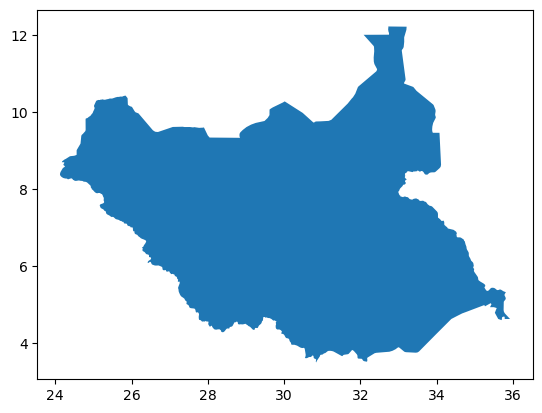

In [9]:
# row = south_sudan.iloc[0]
# coords=np.array(row['geometry'].exterior.coords)
# coords[:,0]=coords[:,0]+360.
# newpoly=Polygon(coords)
# ssdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[newpoly])
# ssdf.plot()

ssdf = south_sudan.reset_index()
ssdf.plot()

In [10]:
ssdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
ss_shape = ssdf.at[0,'geometry']

### Get South Sudanese States

In [12]:
south_sudan_states = provinces.loc[(provinces['admin'] == 'S. Sudan')]
south_sudan_states.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
27,Admin-1 states provinces,3,SDS-892,892,SS-EE,NaN,SS,1,Eastern Equatoria,Al Istiwā'īyah ash Sharqīyah| Sharq al Istiwā'...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((35.26930 5.49178, 35.27364 5.47987, ..."
360,Admin-1 states provinces,3,SDS-873,873,SS-BW,NaN,SS,1,Western Bahr el Ghazal,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((24.26319 8.26851, 24.25705 8.26919, ..."
362,Admin-1 states provinces,3,SDS-864,864,SS-EW,NaN,SS,1,Western Equatoria,Al Istiwā'īyah al Gharbīyah|Gharb al Istiwā'īy...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((26.46493 6.22440, 26.45563 6.23047, ..."
364,Admin-1 states provinces,3,SDS-865,865,SS-EC,NaN,SS,1,Central Equatoria,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((29.81485 4.34676, 29.78782 4.36880, ..."
1113,Admin-1 states provinces,3,SDS-869,869,SS-NU,NaN,SS,1,Upper Nile,Upper Nile|Sobat|a`Ālī an Nīl|Nil supérieur,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((34.10725 8.60153, 34.10317 8.57932, ..."


<Axes: >

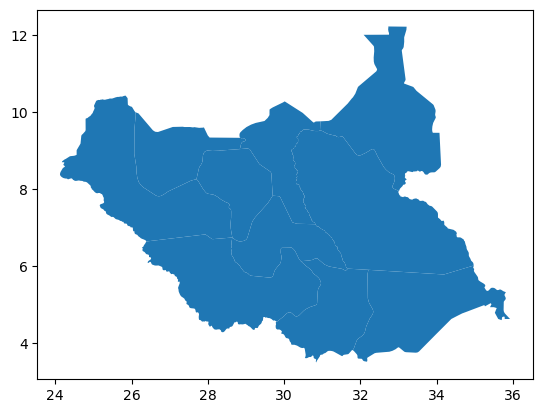

In [13]:
south_sudan_states.plot()

## Get Violence Data

### UCDP (Uppsala Conflict Data Program) API. https://ucdp.uu.se/apidocs/

In [14]:
baseurl = "https://ucdpapi.pcr.uu.se/api/gedevents/23.1"
params = {"pagesize":1, "page":1,"Country":626, "StartDate":"2020-01-01", "EndDate":"2021-01-01"}

r = requests.get(baseurl, params=params)

In [15]:
r.json()

{'TotalCount': 63,
 'TotalPages': 63,
 'PreviousPageUrl': 'https://ucdpapi.pcr.uu.se/api/gedevents/23.1?pagesize=1&page=0&Country=626&StartDate=2020-01-01&EndDate=2021-01-01',
 'NextPageUrl': 'https://ucdpapi.pcr.uu.se/api/gedevents/23.1?pagesize=1&page=2&Country=626&StartDate=2020-01-01&EndDate=2021-01-01',
 'Result': [{'id': 333617,
   'relid': 'SUD-2020-2-5193-0',
   'year': 2020,
   'active_year': True,
   'code_status': 'Clear',
   'type_of_violence': 2,
   'conflict_dset_id': '5193',
   'conflict_new_id': 4583,
   'conflict_name': 'Agar Dinka - Gok Dinka',
   'dyad_dset_id': '5193',
   'dyad_new_id': 5193,
   'dyad_name': 'Agar Dinka - Gok Dinka',
   'side_a_dset_id': '582',
   'side_a_new_id': 582,
   'side_a': 'Agar Dinka',
   'side_b_dset_id': '583',
   'side_b_new_id': 583,
   'side_b': 'Gok Dinka',
   'number_of_sources': 1,
   'source_article': '"United Nations Security Council Report,2020-02-26,S/2020/145 Situation in South Sudan"',
   'source_office': 'United Nations Secu

## Get Rainfall Data

### Download CMORPH Data
https://www.ncei.noaa.gov/products/climate-data-records/precipitation-cmorph

In [16]:
def downloadRainData(month, day):
  url = 'https://www.ncei.noaa.gov/data/cmorph-high-resolution-global-precipitation-estimates/access/daily/0.25deg/2020/{month:02d}/CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_2020{month:02d}{day:02d}.nc'.format(month=month, day=day)
  r = requests.get(url, allow_redirects=True)
  if r.status_code == 200:
    name = 'cmorph2020{month:02d}{day:02d}.nc'.format(month=month, day=day)
    open('data/cmorph/'+name, 'wb').write(r.content)

In [17]:
for month in range(1,13):
  for day in range(1,32):
    try:
      if not os.path.exists('data/cmorph/cmorph2020{month:02d}{day:02d}.nc'.format(month=month, day=day)):
        downloadRainData(month, day)
        print("Getting 2020/{month:02d}/{day:02d}".format(month=month, day=day), end='\r')
      else:
        print("Skipping 2020/{month:02d}/{day:02d}".format(month=month, day=day), end='\r')
    except Exception as e:
      print(e)
      continue

### Collect CMORPH files into xarray Dataset

In [18]:
# Combine dataset over time
ds = xr.open_mfdataset('./data/cmorph/*.nc', combine="by_coords")
ds

<xarray.Dataset>
Dimensions:      (time: 366, nv: 2, lat: 480, lon: 1440)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * lat          (lat) float32 -59.88 -59.62 -59.38 -59.12 ... 59.38 59.62 59.88
  * lon          (lon) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bounds   (time, lat, nv) float32 dask.array<chunksize=(1, 480, 2), meta=np.ndarray>
    lon_bounds   (time, lon, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    cmorph       (time, lat, lon) float32 dask.array<chunksize=(1, 480, 1440), meta=np.ndarray>
Attributes: (12/57)
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is a reprocessed and bias-corr...
    references:                 Xie, P., et al. (2017), Reprocessed, Bias-Cor...
    Conventions:                CF-1.6, ACDD-1.3
    ...                         ...
    geospatial_lat_resolution:  0.25
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_resolution:  0.25
    geospatial_lon_units:       degrees_east

### Select the rain variable

In [19]:
rain = ds.cmorph
rain.rio.write_crs("EPSG:4326", inplace=True)
rain.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

<xarray.DataArray 'cmorph' (time: 366, lat: 480, lon: 1440)>
dask.array<concatenate, shape=(366, 480, 1440), dtype=float32, chunksize=(1, 480, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * lat          (lat) float32 -59.88 -59.62 -59.38 -59.12 ... 59.38 59.62 59.88
  * lon          (lon) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
    spatial_ref  int64 0
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      NOAA Climate Data Record (CDR) of CPC Morphing Technique ...
    units:          mm/day
    valid_min:      0
    valid_max:      32767
    comment:        !!! CMORPH estimate is rainrate !!!

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


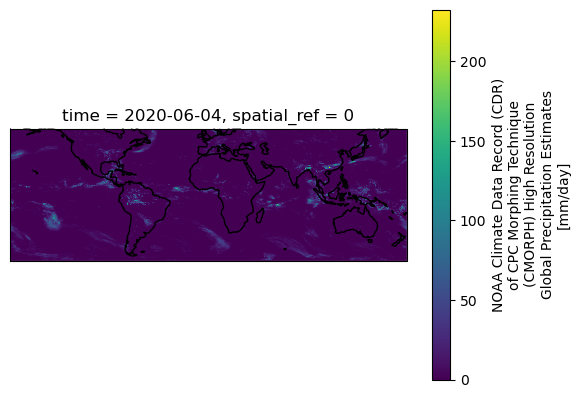

In [20]:
# Plot sample of the data
p = rain.isel(time=155).plot(
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)
p.axes.coastlines()

### Clip the data to only within South Sudan

In [21]:
rain_clipped = rain.rio.clip(ssdf.geometry.apply(mapping), ssdf.crs, drop=True, invert=False)
rain_clipped

<xarray.DataArray 'cmorph' (time: 366, lat: 35, lon: 48)>
dask.array<getitem, shape=(366, 35, 48), dtype=float32, chunksize=(1, 35, 48), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * lat          (lat) float32 3.625 3.875 4.125 4.375 ... 11.62 11.88 12.12
  * lon          (lon) float32 24.12 24.38 24.62 24.88 ... 35.38 35.62 35.88
    spatial_ref  int64 0
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      NOAA Climate Data Record (CDR) of CPC Morphing Technique ...
    units:          mm/day
    valid_min:      0
    valid_max:      32767
    comment:        !!! CMORPH estimate is rainrate !!!

In [22]:
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces',
        scale='10m',
        facecolor='none')
bounds = [21.663731325314046,39.249959603957706,0.8838107955052976,13.743619196613025]

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


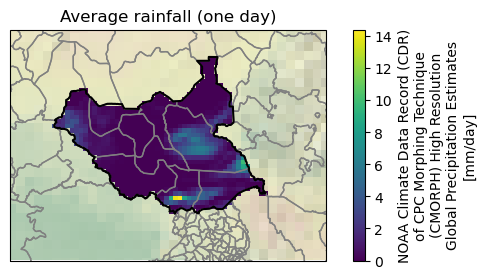

In [23]:
fig=plt.figure(figsize=(7,3))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
rain_clipped.isel(time=155).plot(ax=ax)

ssdf.boundary.plot(ax=ax,color='black')
plt.title('Average rainfall (one day)')
ax.add_feature(states_provinces, edgecolor='gray')
ax.set_extent(bounds, crs=ccrs.PlateCarree())
ax.stock_img()

plt.show()
p.axes.coastlines()

### Get average rainfall for all of 2020

In [24]:
average_rain_year = rain_clipped.mean(dim='time') # Compressing over the time variable to display rainfall "heatmap"

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


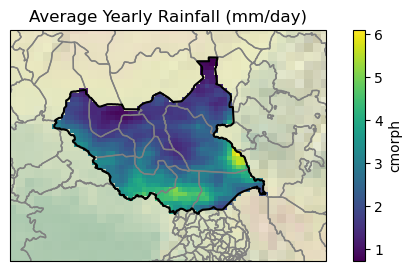

In [25]:
fig=plt.figure(figsize=(7,3))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
average_rain_year.plot(ax=ax)

ssdf.boundary.plot(ax=ax,color='black')
plt.title('Average Yearly Rainfall (mm/day)')
ax.add_feature(states_provinces, edgecolor='gray')
ax.set_extent(bounds, crs=ccrs.PlateCarree())
ax.stock_img()

plt.show()
p.axes.coastlines()

----

## Average rainfall per state

In [76]:
states = south_sudan_states[['name', 'geometry']].reset_index(drop=True)
states = states.astype({'name':'string'})

In [213]:
df = rain_clipped.to_dataframe()
df = df.reset_index()

In [214]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat, crs="EPSG:4326"))
gdf = gdf.drop(['lat', 'lon'], axis=1)
gdf = gdf.dropna()
gdf

,time,spatial_ref,cmorph,geometry
26,2020-01-01,0,0.0,POINT (30.62500 3.62500)
27,2020-01-01,0,0.0,POINT (30.87500 3.62500)
32,2020-01-01,0,0.0,POINT (32.12500 3.62500)
74,2020-01-01,0,0.0,POINT (30.62500 3.87500)
75,2020-01-01,0,0.0,POINT (30.87500 3.87500)
...,...,...,...,...
614818,2020-12-31,0,0.0,POINT (32.62500 11.87500)
614819,2020-12-31,0,0.0,POINT (32.87500 11.87500)
614820,2020-12-31,0,0.0,POINT (33.12500 11.87500)
614867,2020-12-31,0,0.0,POINT (32.87500 12.12500)


### Join raster data with states

In [216]:
cdf = gpd.sjoin(states, gdf, how="inner")
cdf = cdf[['name', 'time', 'geometry', 'cmorph']]
cdf = cdf.reset_index(drop=True)
cdf

,name,time,geometry,cmorph
0,Eastern Equatoria,2020-01-04,"POLYGON ((35.26930 5.49178, 35.27364 5.47987, ...",0.3
1,Eastern Equatoria,2020-01-07,"POLYGON ((35.26930 5.49178, 35.27364 5.47987, ...",0.0
2,Eastern Equatoria,2020-07-12,"POLYGON ((35.26930 5.49178, 35.27364 5.47987, ...",0.2
3,Eastern Equatoria,2020-11-27,"POLYGON ((35.26930 5.49178, 35.27364 5.47987, ...",6.3
4,Eastern Equatoria,2020-07-22,"POLYGON ((35.26930 5.49178, 35.27364 5.47987, ...",1.6
...,...,...,...,...
301579,Warrap,2020-10-07,"POLYGON ((28.37453 8.99056, 28.38445 8.99242, ...",0.0
301580,Warrap,2020-11-27,"POLYGON ((28.37453 8.99056, 28.38445 8.99242, ...",0.0
301581,Warrap,2020-05-31,"POLYGON ((28.37453 8.99056, 28.38445 8.99242, ...",1.0
301582,Warrap,2020-08-30,"POLYGON ((28.37453 8.99056, 28.38445 8.99242, ...",0.3


### Group by state and day

In [149]:
states_rainfall = cdf[['name','time','cmorph']].groupby(['name','time']).mean().reset_index()
states_rainfall = states_rainfall.astype({'name':'string'})
states_rainfall

,name,time,cmorph
0,Central Equatoria,2020-01-01,0.000000
1,Central Equatoria,2020-01-02,0.000000
2,Central Equatoria,2020-01-03,0.001538
3,Central Equatoria,2020-01-04,0.001538
4,Central Equatoria,2020-01-05,0.000000
...,...,...,...
3655,Western Equatoria,2020-12-27,0.000000
3656,Western Equatoria,2020-12-28,0.000000
3657,Western Equatoria,2020-12-29,0.000000
3658,Western Equatoria,2020-12-30,0.000000


In [175]:
states_rainfall.describe()

,time,cmorph
count,3660,3660.000000
mean,2020-07-01 11:59:59.999999744,2.368366
min,2020-01-01 00:00:00,0.000000
25%,2020-04-01 00:00:00,0.000000
50%,2020-07-01 12:00:00,0.383333
75%,2020-10-01 00:00:00,2.750240
max,2020-12-31 00:00:00,48.583332
std,NaN,4.447538


### Create weekly and monthly level averages

In [206]:
weekly_rainfall_state = states_rainfall.groupby(['name',states_rainfall['time'].dt.strftime('%Y-%W')])['cmorph'].mean().reset_index()
monthly_rainfall_state = states_rainfall.groupby(['name',states_rainfall['time'].dt.month])['cmorph'].mean().reset_index()

<Axes: xlabel='time'>

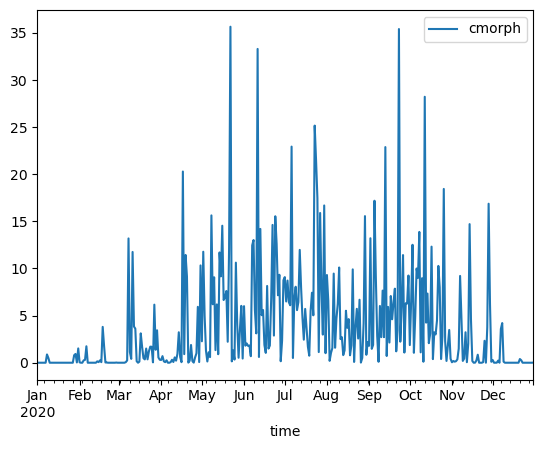

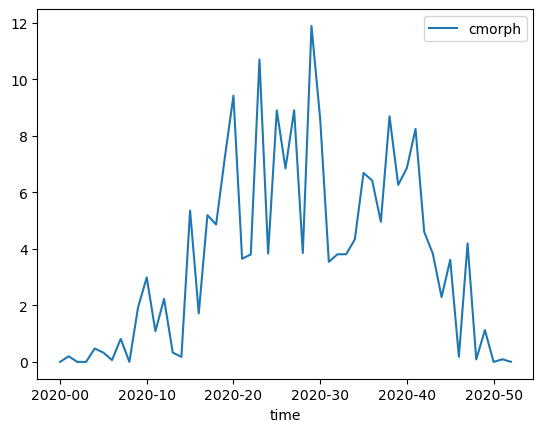

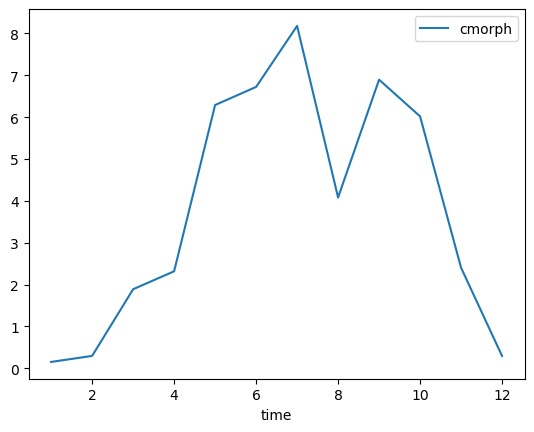

In [209]:
states_rainfall[states_rainfall['name']=='Central Equatoria'].plot('time','cmorph')
weekly_rainfall_state[weekly_rainfall_state['name']== 'Central Equatoria'].plot('time','cmorph')
monthly_rainfall_state[monthly_rainfall_state['name']== 'Central Equatoria'].plot('time','cmorph')

### Plot average rainfall

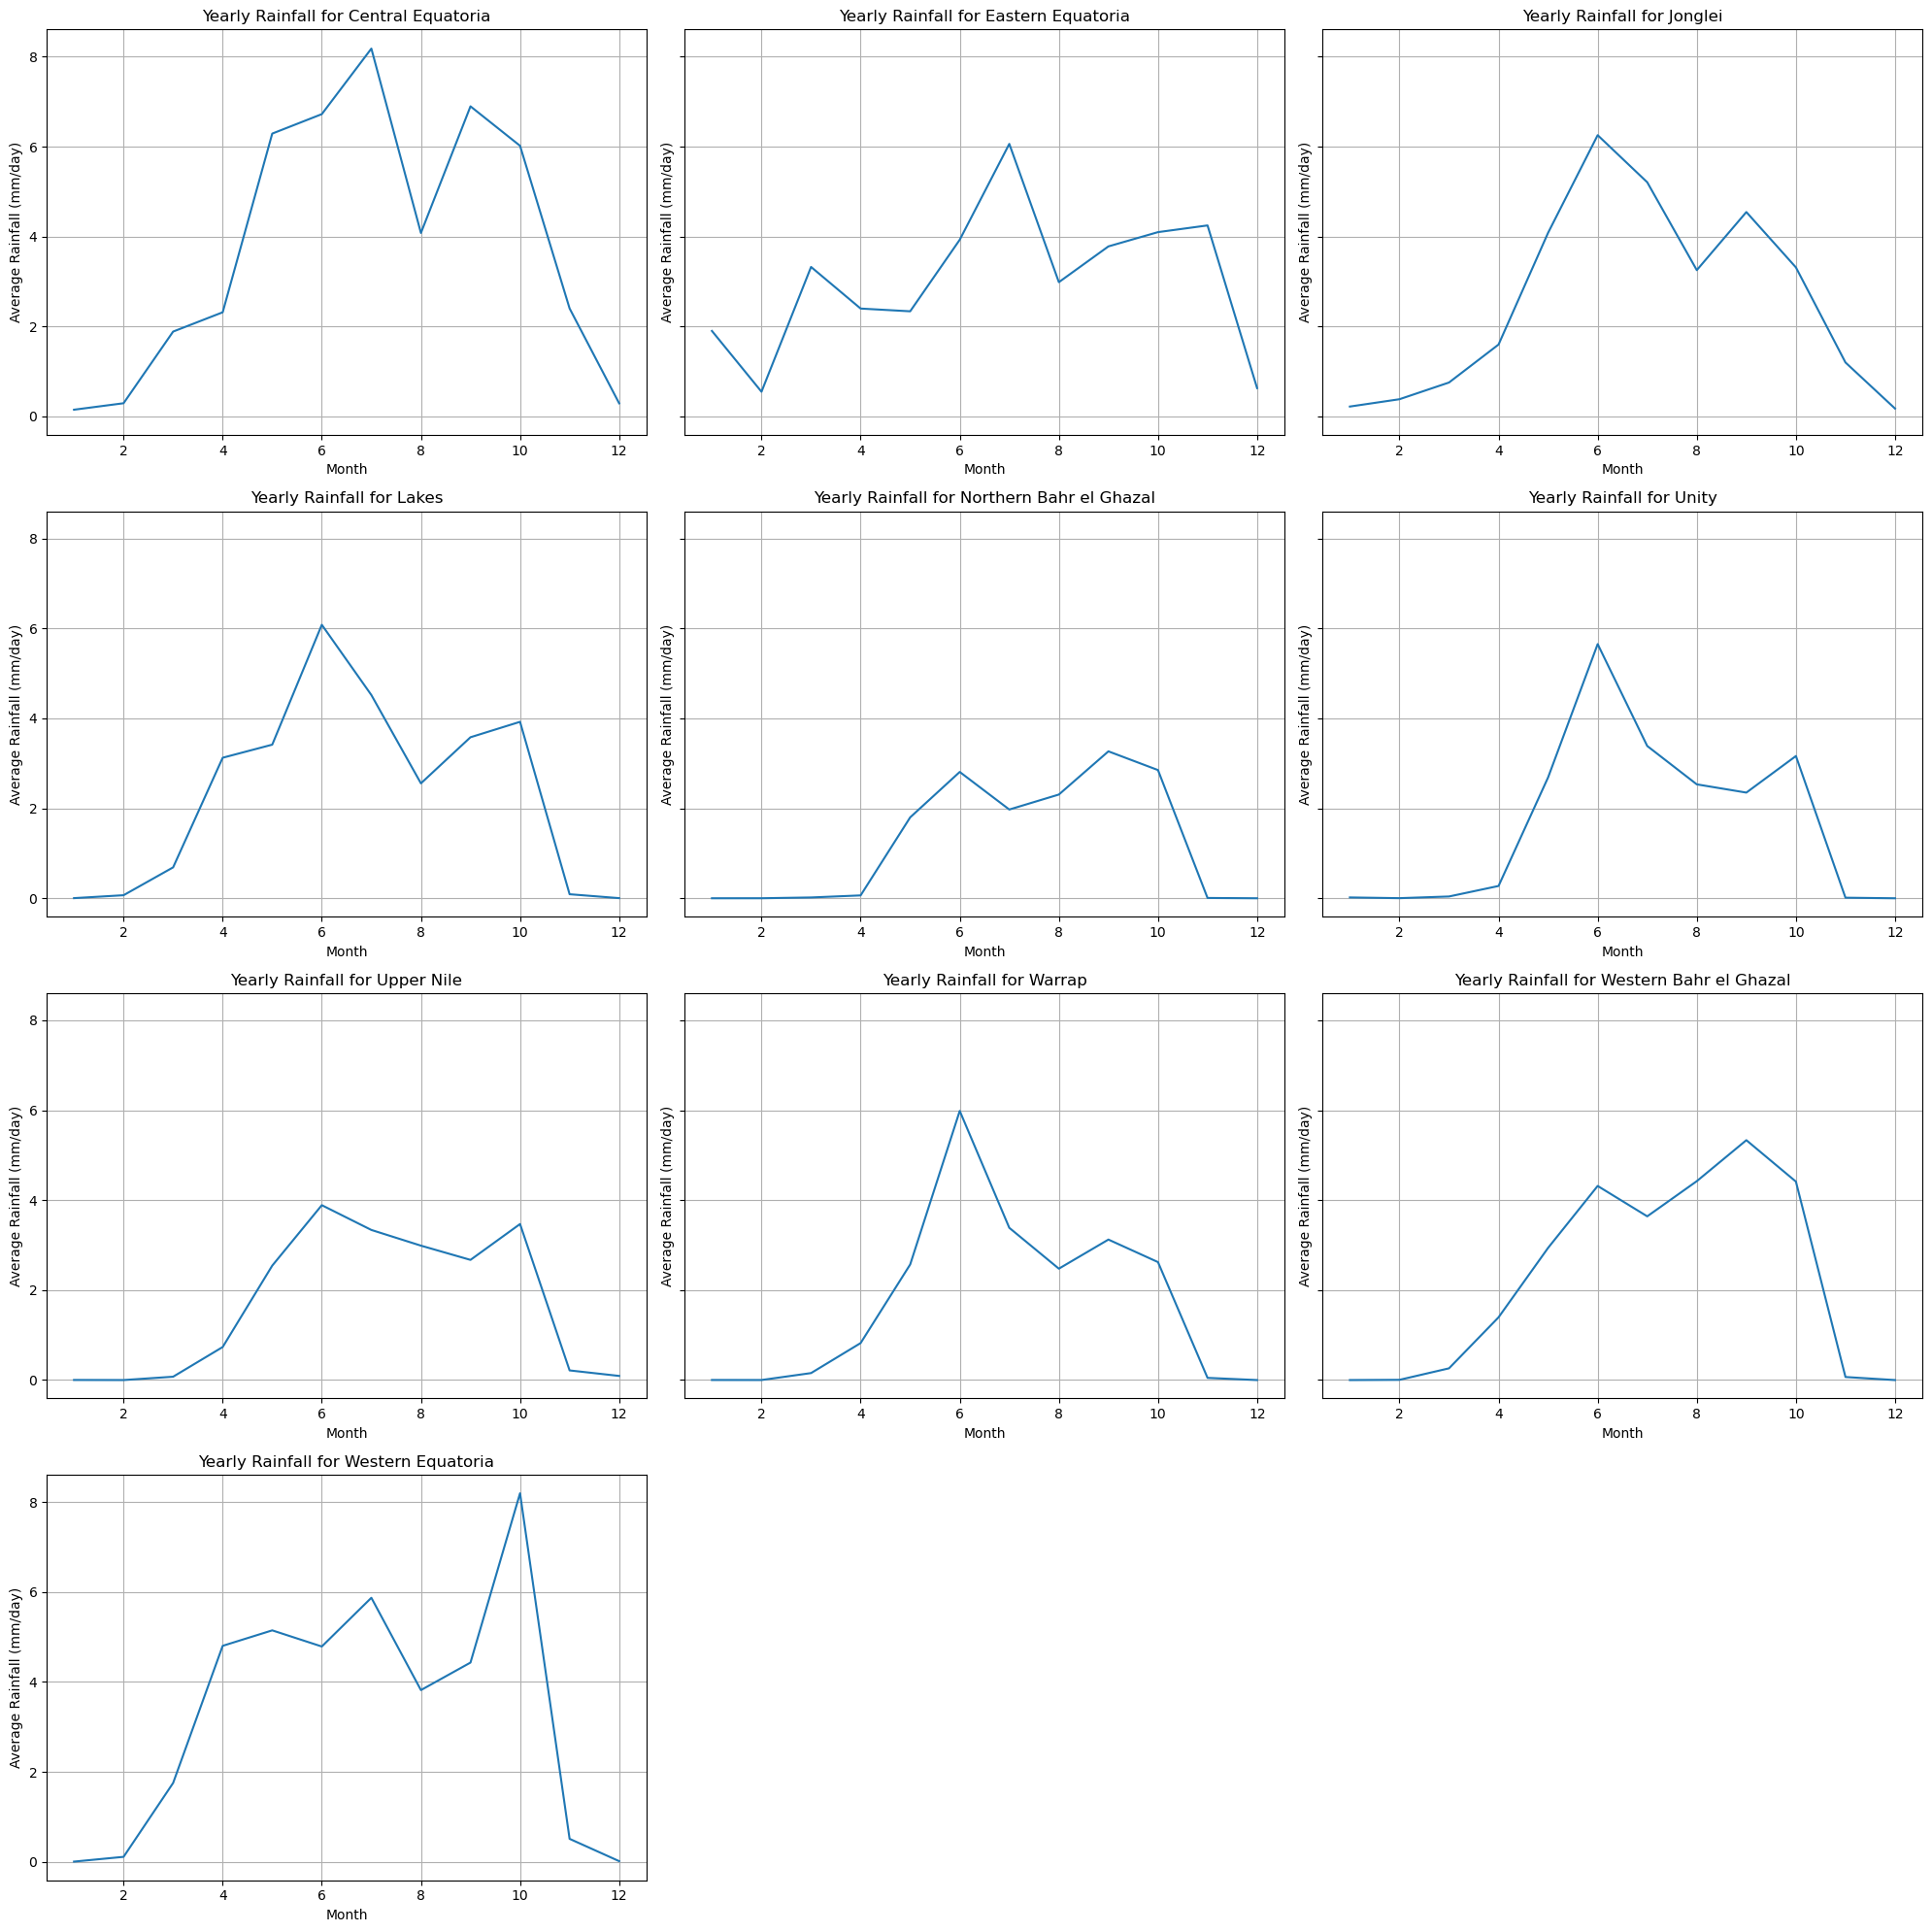

In [215]:
# Get unique names
unique_names = states_rainfall['name'].unique()

# Calculate the number of rows and columns for the grid
num_subplots = len(unique_names)
num_cols = 3
num_rows = math.ceil(num_subplots / num_cols)

# Create subplots with a 3-column grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows), sharey=True)

# Loop through unique names and create scatterplots
for i, name in enumerate(unique_names):
    row = i // num_cols
    col = i % num_cols
    
    daily_df = states_rainfall[states_rainfall['name'] == name]
    weekly_df = weekly_rainfall_state[weekly_rainfall_state['name']== name]
    monthly_df = monthly_rainfall_state[monthly_rainfall_state['name']== name]
    
    # axes[row, col].scatter(subset_df['time'], subset_df['cmorph'], s=10)
    axes[row, col].plot(monthly_df['time'], monthly_df['cmorph'])

    axes[row, col].set_xlabel('Month')
    axes[row, col].set_ylabel('Average Rainfall (mm/day)')
    axes[row, col].set_title(f'Yearly Rainfall for {name}')
    # axes[i].axhline(y=np.nanmean(states_avg_rainfall.cmorph), color='red', linestyle='--', linewidth=3, label='Avg')
    axes[row, col].grid()

# Remove any empty subplots
for i in range(num_subplots, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()